# Lab 3 - Part 1: Classification and Grid Search (33 marks)
### Due Date: Monday, March 13 at 12pm

Author: Michael Le

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

The purpose of this portion of the assignment is to practice following the grid-search workflow: 
- Split data into training and test set
- Use the training portion to find the best model using grid search and cross-validation
- Retrain the best model
- Evaluate the retrained model on the test set

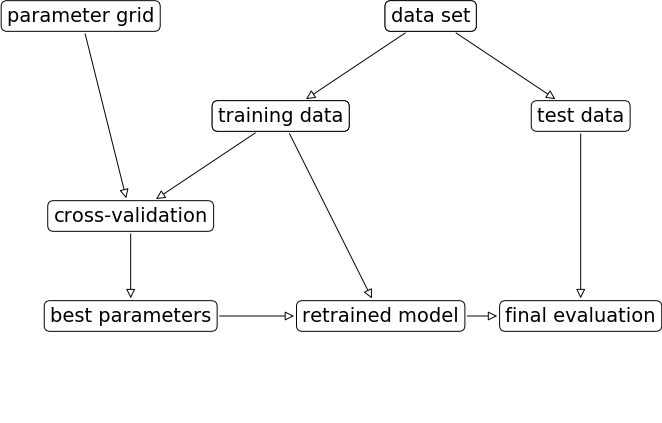

In [2]:
import mglearn
mglearn.plots.plot_grid_search_overview()

## 0. Function definitions (2 marks)

In [27]:
from sklearn.model_selection import cross_validate


def get_classifier_cv_score(model, X, y, scoring='accuracy', cv=7):
    '''Calculate train and validation scores of classifier (model) using cross-validation
        
        
        model (sklearn classifier): Classifier to train and evaluate
        X (numpy.array or pandas.DataFrame): Feature matrix
        y (numpy.array or pandas.Series): Target vector
        scoring (str): a scoring string accepted by sklearn.metrics.cross_validate()
        cv (int): number of cross-validation folds see sklearn.metrics.cross_validate()
        
        returns: mean training score, mean validation score
    
    '''
    
    #TODO: Implement function body
    # Returns a dictionary with the training and testing times for each validation, as well as the training and testing scores
    result = cross_validate(model, X, y, cv=cv, return_train_score=True, scoring=scoring)
    df = pd.DataFrame.from_dict(result, orient='columns', dtype=None, columns=None)
    # print(df)
    mean_train_score = df["train_score"].mean()
    mean_test_score = df["test_score"].mean()
    # print(mean_train_score, mean_test_score)
    return (mean_train_score, mean_test_score)

In [3]:
# DO NOT NEED TO ADD ANYTHING TO THIS FUNCTION
def print_grid_search_result(grid_search):
    '''Prints summary of best model from GridSearchCV object.
    
        For the best model of the grid search, print:
        - parameters 
        - cross-validation training score
        - cross-validation validation score 
        
        scores are printed with 3 decimal places
    
        grid_search (sklearn GridSearchCV): Fitted GridSearchCV object
        
        returns: None
        
    '''
    
    print(grid_search.best_params_)
    print("training score= {:.3f}; validation score={:.3f}".format(grid_search.cv_results_['mean_train_score'][grid_search.best_index_],
                                                                  grid_search.cv_results_['mean_test_score'][grid_search.best_index_]))

In [5]:
# DO NOT NEED TO ADD ANYTHING TO THIS FUNCTION
import mglearn

def plot_grid_search_results(grid_search):
    '''For grids with 2 hyperparameters, create a heatmap plot of test scores
        
        grid_search (sklearn GridSearchCV): Fitted GridSearchCV object
        
        uses mglearn.tools.heatmap() for plotting
    
    '''
    results = pd.DataFrame(grid_search.cv_results_)

    params = sorted(grid_search.param_grid.keys())
    
    assert len(params) == 2, "We can only plot two parameters."
    
    # second dimension in reshape are rows, needs to be the fast changing parameter
    scores = np.array(results.mean_test_score).reshape(len(grid_search.param_grid[params[0]]),
                                                      len(grid_search.param_grid[params[1]]))

    # plot the mean cross-validation scores
    # x-axis needs to be the fast changing parameter
    mglearn.tools.heatmap(scores, 
                          xlabel=params[1], 
                          xticklabels=grid_search.param_grid[params[1]], 
                          ylabel=params[0], 
                          yticklabels=grid_search.param_grid[params[0]],
                          cmap="viridis", fmt="%0.3f")

In [6]:
# DO NOT NEED TO ADD ANYTHING TO THIS FUNCTION
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y_actual, y_pred, labels, title):
    '''Creates a heatmap plot of the confusion matrix.
    
        y_actual (pandas.DataSeries or numpy.Array): Ground truth label vector
        y_pred (pandas.DataSeries or numpy.Array): Predicted label vector
        labels (list(str)): Class names used for plotting (ticklabels)
        title (str): Plot title
        
        uses sklearn.metrics.confusion_matrix
        
    '''
    
    mat = confusion_matrix(y_actual, y_pred)

    sns.heatmap(mat, 
                xticklabels=labels,  
                yticklabels=labels, 
                square=True, annot=True, cbar=False, 
                fmt='d')
    plt.xlabel('predicted value')
    plt.ylabel('true value')
    plt.title(title)

## 1. Load data (2 marks)
yellowbrick mushroom  
https://www.scikit-yb.org/en/latest/api/datasets/mushroom.html




### 1.1 Prepare the feature matrix and target vector

Using the yellowbrick `load_mushroom()` function, load the mushroom data set into feature matrix `X` and target vector `y`

Print shape and type of `X`, `y`

In [9]:
# TODO: Add data loading code
from yellowbrick.datasets.loaders import load_mushroom

X, y = load_mushroom()

print(f"Shape of X: {X.shape}")
print(f"Shape of y: {y.shape}\n")
print(f"Type of X columns: \n{X.dtypes}\n")
print(f"Type of X: \n{X.dtypes.dtype}\n")
print(f"Type of y: \n{y.dtypes}\n")

Shape of X: (8123, 3)
Shape of y: (8123,)

Type of X columns: 
shape      object
surface    object
color      object
dtype: object

Type of X: 
object

Type of y: 
object



## 2. Preprocessing (4 marks)
In this dataset, all features are discrete and nominal and need to be encoded. We will use a `OneHotEncoder`

The target vector is discrete and nominal as well and contains string labels. While sklearn is OK using string labels in target vectors, you will use a `LabelEncoder` explicitly to convert strings to integers and keep the encoder to translate between the two representations

### 2.1 Onehot encoding of features
Use `OneHotEncoder` to convert `X` into one-hot-encoded features stored in a variable `X_enc`. Use `sparse=False`. Print shape of `X_enc`

In [16]:
# TODO: Add OneHotEncoder here
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder(sparse=False)
encoder.fit(X)
X_enc = encoder.transform(X)

print(f"Shape of X_enc: {X_enc.shape}")

Shape of X_enc: (8123, 20)


### 2.2 Label encode target vector 
Use `LabelEncoder` to encode the target vector `y`, saved in a variable `y_enc`

Print the resulting target vector `y_enc` and print the class names available in the `classes_` attribute of the `LabelEncoder` object

In [53]:
# TODO: Add LabelEncoder here
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
encoder.fit(y)
y_enc = encoder.transform(y)

print(y_enc)
print(f"Class names in LabelEncoder object: {encoder.classes_}")

[0 0 1 ... 0 1 0]
Class names in LabelEncoder object: ['edible' 'poisonous']


## 3. Create training and test sets (1 mark)
Using scikit-learn `train_test_split()` with parameters `random_state=37`, `test_size=0.2`, split `X_enc` and `y_enc` into training and test sets

In [21]:
# TODO: Add train_test_split() here
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_enc, y_enc, test_size=0.2, random_state=37)

## 4. Compare models using cross-validation (4 marks)
Create a list containing `LogisticRegression()`, 
          `SVC()`,
          `BernoulliNB()`,
        `RandomForestClassifier(random_state=55)`, 
         `GradientBoostingClassifier(random_state=56)` objects.

Iterate this list, then:
- Compute the **f1 score** using `get_classifier_cv_score()` with the 7-fold cross-validation defined above with `X_train` and `y_train` as arguments
- Print the models' training and validation scores with **3 decimal places**

In [29]:
# TODO: Add cross-validation comparison here
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import f1_score
import numpy as np

models = [LogisticRegression(), SVC(), BernoulliNB(), RandomForestClassifier(random_state=55), 
        GradientBoostingClassifier(random_state=56)]

scores = []

for model in models:
    train_score, val_score = get_classifier_cv_score(model, X_train, y_train, scoring='f1')
    score_dict = {'Model': model.__class__.__name__, 'Train Score': '{:.3f}'.format(train_score), 
                  'Validation Score': '{:.3f}'.format(val_score)}
    scores.append(score_dict)
    
df = pd.DataFrame(scores)
print(df)
    

                        Model Train Score Validation Score
0          LogisticRegression       0.663            0.664
1                         SVC       0.691            0.678
2                 BernoulliNB       0.614            0.613
3      RandomForestClassifier       0.692            0.678
4  GradientBoostingClassifier       0.702            0.692


## 5. Hyperparameter tuning using grid search (8 marks)

The inital cross-validation above gives us an idea of how algorithms perfom using their default hyperparameters

Next, we will try and improve one model by tuning its hyperparameters using grid search

### 5.1 Grid search for RandomForestClassifier 

Perform grid search using `GridSearchCV` for the `RandomForestClassifier(n_estimators=300, random_state=55)`:

- Set the number of trees `n_estimators=300` for all evaluations
- Grid search using 7-fold cross-validation and `f1` as the scoring function 
- Note that there is a `n_jobs` parameter to run search in parallel. Setting it to the number of CPU cores  or -1 works well

Use the following hyperparameters and values:
- `'max_depth': [3, 5, 8]`
- `'max_features': [0.3, 0.5, 0.7, 0.9]`

From sklearn help:
> - max_depth: The maximum depth of the tree
> - max_features: If float, then max_features is a fraction and max(1, int(max_features * n_features)) features are considered at each split


Use the `print_grid_search_result()` and `plot_grid_search_result()` functions defined above to show the results

In [32]:
# TODO: Setup grid search for RandomForestClassifier(random_state=55)
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

param_grid = {'max_depth': [3, 5, 8], 'max_features': [0.3, 0.5, 0.7, 0.9]}
model = RandomForestClassifier(n_estimators=300, random_state=55)
grid_search = GridSearchCV(model, param_grid, scoring='f1', cv=7, n_jobs=-1, return_train_score=True)

In [33]:
# TODO: Perform the grid search by calling fit() with X_train and y_train
grid_search.fit(X_train, y_train)

GridSearchCV(cv=7,
             estimator=RandomForestClassifier(n_estimators=300,
                                              random_state=55),
             n_jobs=-1,
             param_grid={'max_depth': [3, 5, 8],
                         'max_features': [0.3, 0.5, 0.7, 0.9]},
             return_train_score=True, scoring='f1')

In [34]:
# TODO: Call print_grid_search_result() to print the results
print_grid_search_result(grid_search)

{'max_depth': 5, 'max_features': 0.7}
training score= 0.719; validation score=0.716


### *Question 1:* What is the validation score of the best model? Which models in Section 4 does it outperform?

The validation score of the best RandomForestClassifier model is 0.716, when max_depth is 5 and max_features is 0.7. Compared to the models in section 4, this model outperforms all of them when tuned for hyperparameters.


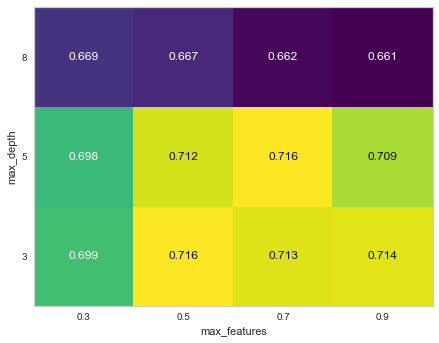

In [35]:
# TODO: Call plot_grid_search_results() to plot validation metrics for all hyperparameter combinations
plot_grid_search_results(grid_search)

### *Question 2:* Where in the hyperparameter ranges does the maximum occur? Would you need to adjust the hyperparameter ranges to find a better model?

From the heatmap, the maximum occurs when max_depth=3 and max_features=0.5, and when max_depth=5 and max_features=0.7. Both of these hyperparameter ranges return a validation score of 0.716. From these results, there does not seem to be any huge outliers and the hyperparameter ranges seem reasonable, so there is no need for adjustment to find a better model. Increasing the range would probably result in overfitting and a decrease in range would probably result in underfitting. 

## 6. Re-train best model (2 marks)
Re-train the best `RandomForestClassifier()` from the grid search above on the training dataset `X_train` and `y_train`

In [40]:
#TDOD: Re-train best random forest classifier
best_model = grid_search.best_estimator_
best_model.fit(X_train, y_train)

RandomForestClassifier(max_depth=5, max_features=0.7, n_estimators=300,
                       random_state=55)

## 7. Evaluate using test data (4 marks)

Using the retrained model and the test dataset `X_test` and `y_test`:
- plot the confusion matrix using the `plot_confusion_matrix()` function defined above
- print the classification report

Make sure the plot has class labels and a title

### 7.1 Confusion matrix and classification report

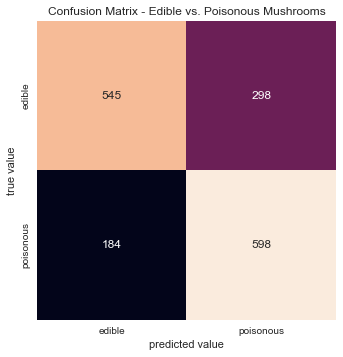

In [54]:
#TODO: call plot_confusion_matrix(), use LabelEncoder classes_ to get labels
from sklearn.metrics import classification_report

y_pred = best_model.predict(X_test)

plot_confusion_matrix(y_test, y_pred, encoder.classes_, title='Confusion Matrix - Edible vs. Poisonous Mushrooms')

### 7.2 Classification report

In [55]:
#TODO: print classification report using default threshold
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.75      0.65      0.69       843
           1       0.67      0.76      0.71       782

    accuracy                           0.70      1625
   macro avg       0.71      0.71      0.70      1625
weighted avg       0.71      0.70      0.70      1625



### *Question 3:* What are the precision, recall and accuracy for the positive class on the test set?

For the positive class:
Precision is 0.67.
Recall is 0.76.
Accuracy is 0.71.

### *Question 4:* How many false negatives and false positives does the model produce on the test set?

There are 298 false positives and 184 false negatives.


## 8. Conclusion (4 marks)

In the conclusion, comment on the following items and use data to support your findings:
1. In the classification of edible vs poisonous mushrooms, what do false positive and false negative predictions imply and what are the consequences of making these mistakes?
1. In the classification of edible vs poisonous mushrooms, why is high recall desired?
1. Reflect on the usefulness of this model if it would be put into production and propose ways to improve the model and/or application

*YOUR ANSWER HERE*
1. A false positive indicates that a mushroom is poisonous, when it is actually edible. The consequences of this false positive is that these edible mushrooms will be wasted and disposed of, leading to unnecessary financial losses for mushroom producers and distributors. A false negative predicts that a mushroom is edible when it is actually poisonous. The consequences of this false negative can be deadly, as consumption of a poisonous mushroom can lead to death or illness.

2. High recall is desired in this classification of edible vs poisonous mushrooms, because it would mean the number of false negatives is low and that the model has a high number of true positives. This means that most of the poisonous mushrooms were correctly identified which minimizes the chances of people consuming poisonous mushrooms they thought were edible.

3. This model would be useful if it were put into production, since it would give mushroom producers, distributors, and consumers an idea of how many edible mushrooms are wasted and how many poisonous mushrooms are made available for sale. To improve the model, we could collect more data samples and use a larger, more varied sample size that would better reflect the characteristics of edible and poisonous mushrooms.


## 9. Reflection (2 marks)
Include a sentence or two about:
- what you liked or disliked,
- found interesting, confusing, challangeing, motivating while working on this assignment 

Can include thoughts from Lab 3-2 as well

I really liked how this assignment allowed us to create a model and tinker with the hyperparameters using grid search for a real-world application like the mushroom dataset. It was fun being able to use the confusion matrix to explain how many mushrooms were falsely classified as edible or poisonous, and explain the real-world consequences of these results. Overall, this assignment set a great example of how I can approach a classification machine learning problem from start to finish for the future, when I want to use the same approach for data and problems I am interested in.
